In [1]:
import umap

/home/tsuman/All_Files/Program_Files/miniconda/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-24 23:01:54.114342: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-24 23:01:54.644997: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-12-24 23:01:54.645046: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
# from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import datasets, transforms as T

import random, os, pathlib, time
from tqdm import tqdm
# from sklearn import datasets

In [3]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

In [4]:
from tqdm import tqdm
import os, time, sys
import json

In [5]:
import dtnnlib as dtnn

In [6]:
mnist_transform = T.Compose([
    T.ToTensor(),
#     T.Normalize(
#         mean=[0.5,],
#         std=[0.5,],
#     ),
])

train_dataset = datasets.FashionMNIST(root="../../../../_Datasets/", train=True, download=True, transform=mnist_transform)
test_dataset = datasets.FashionMNIST(root="../../../../_Datasets/", train=False, download=True, transform=mnist_transform)

In [7]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

In [8]:
for xx, yy in train_loader:
    xx, yy = xx.to(device), yy.to(device)
    print(xx.shape, yy.shape)
    break

torch.Size([50, 1, 28, 28]) torch.Size([50])


In [9]:
xx.min(), xx.max()

(tensor(0.), tensor(1.))

In [10]:
train_dataset.data.shape, train_dataset.targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [11]:
embed = umap.UMAP(n_neighbors=50, n_components=2, min_dist=0.1, spread=1)
# embed = umap.UMAP(n_neighbors=784, n_components=2, min_dist=0.1, spread=1,
# #                   target_metric='euclidean',
#                   target_metric='categorical',
#                   target_weight=0.1
#                  )

In [12]:
selected_points = test_dataset.data.reshape(-1, 28*28).type(torch.float32)/255
embedding = embed.fit_transform(selected_points)
# embedding = embed.fit_transform(centers, output_cent)

In [13]:
for xx, yy in train_loader:
    xx = xx.reshape(-1, 28*28)
    print(xx.shape, yy.shape)
    break

torch.Size([50, 784]) torch.Size([50])


In [14]:
xx.max()

tensor(1.)

In [15]:
xtransf = embed.transform(xx.numpy().reshape(-1, 28*28))

In [16]:
xx.max()

tensor(1.)

In [17]:
transform = dtnn.DistanceTransformBase(28*28, len(test_dataset))
transform.centers.data = selected_points

In [18]:
test_dataset.targets

tensor([9, 2, 1,  ..., 8, 1, 5])

In [19]:
# transform = nn.Linear(784, 785)


In [20]:
i = -1

In [21]:
i += 1
with torch.no_grad():
    dists = transform(xx[i:i+1])
dists.shape
print(yy[i])

tensor(4)


index:0/1


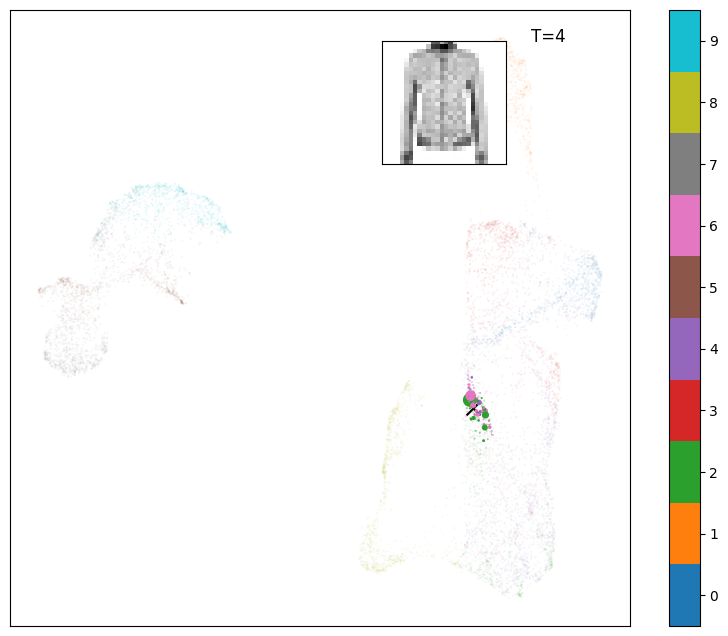

In [22]:
activ = dists.data.cpu().numpy()[0]

# activ = -activ ## use for linear only
activ = activ - activ.min()
activ = np.exp(-activ*7) #*0.05 for linear *3 for dist

print(f"index:{i}/{len(dists)}")
fig = plt.figure(figsize=(10,8))

plt.scatter(xtransf[i,0], xtransf[i,1], marker='x', color='k', s=100)

plt.text(.84, .97, f'T={int(yy[i])}', ha='left', va='top', transform=fig.axes[0].transAxes, fontsize="large")

plt.scatter(embedding[:,0], embedding[:, 1], c=test_dataset.targets, s=np.maximum(activ*80, 0.001), cmap="tab10")
#     plt.scatter(embedding[:,0], embedding[:, 1], c=output_cent, s=np.maximum(activ*80, 0.0), cmap="tab10")

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

ins = plt.gca().inset_axes([0.6,0.75,0.2,0.2])
ins.imshow(xx[i].numpy().reshape(28, 28), cmap='gray_r')
ins.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

plt.show()


In [23]:
activ.max()

1.0

In [24]:
def get_sigma(dists, k=50, epoch=700):
    dists = torch.topk(dists, k=k,dim=1)[0]
    sigma = nn.Parameter(torch.std(dists.data, dim=1, keepdim=True)*0.2)
    optim = torch.optim.Adam([sigma], lr=0.03)
    target = torch.log2(torch.ones_like(sigma)*k).to(dists.device)
    print(sigma, target)
    for i in range(epoch):
        delta = torch.sum(torch.exp(-dists/sigma), dim=1, keepdim=True)
        print(delta.data, sigma.data)
        delta = delta-target

        optim.zero_grad()
        error = (delta**2).sum()
        error.backward()
        optim.step()
    print(sigma, delta)
    return sigma.data

In [25]:
sigma = get_sigma(dists)

Parameter containing:
tensor([[0.1109]], requires_grad=True) tensor([[5.6439]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
te

tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]]) tensor([[0.1109]])
tensor([[0.]])

## Get scale to top-k points

In [26]:
!mkdir outputs/03.4_visualize

mkdir: cannot create directory ‘outputs/03.4_visualize’: File exists


In [27]:
i = -1

In [75]:
i += 1
with torch.no_grad():
    dists = transform(xx[i:i+1])
dists.shape
print(yy[i])

tensor(5)


In [76]:
dists = dists-dists.min(dim=1, keepdim=True)[0]
# dists = torch.topk(dists, k=50,dim=1)[0]
sigma = get_sigma(dists, k=10000)
topk_dists = torch.exp(-dists/sigma)

Parameter containing:
tensor([[0.6925]], requires_grad=True) tensor([[13.2877]])
tensor([[70.4445]]) tensor([[0.6925]])
tensor([[63.2320]]) tensor([[0.6625]])
tensor([[56.5050]]) tensor([[0.6328]])
tensor([[50.2995]]) tensor([[0.6036]])
tensor([[44.6396]]) tensor([[0.5751]])
tensor([[39.5352]]) tensor([[0.5476]])
tensor([[34.9812]]) tensor([[0.5212]])
tensor([[30.9586]]) tensor([[0.4961]])
tensor([[27.4368]]) tensor([[0.4724]])
tensor([[24.3767]]) tensor([[0.4501]])
tensor([[21.7342]]) tensor([[0.4294]])
tensor([[19.4636]]) tensor([[0.4103]])
tensor([[17.5195]]) tensor([[0.3926]])
tensor([[15.8593]]) tensor([[0.3764]])
tensor([[14.4438]]) tensor([[0.3617]])
tensor([[13.2381]]) tensor([[0.3482]])
tensor([[12.2115]]) tensor([[0.3361]])
tensor([[11.3373]]) tensor([[0.3251]])
tensor([[10.5928]]) tensor([[0.3152]])
tensor([[9.9587]]) tensor([[0.3063]])
tensor([[9.4185]]) tensor([[0.2984]])
tensor([[8.9587]]) tensor([[0.2914]])
tensor([[8.5675]]) tensor([[0.2852]])
tensor([[8.2354]]) tensor(

tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tenso

tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tensor([[0.3488]])
tensor([[13.2877]]) tenso

In [77]:
topk_dists.shape

torch.Size([1, 10000])

In [78]:
topk_dists.max(), topk_dists.min()

(tensor(1.), tensor(3.9421e-22))

index:9/1


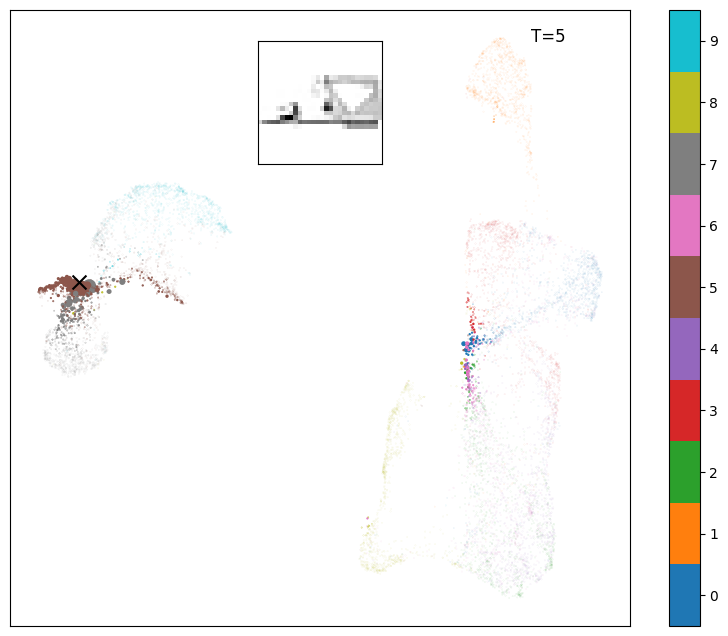

In [79]:
activ = topk_dists.data.cpu().numpy()[0]

print(f"index:{i}/{len(dists)}")
fig = plt.figure(figsize=(10,8))

plt.scatter(embedding[:,0], embedding[:, 1], c=test_dataset.targets, s=np.maximum(activ*80, 0.001), cmap="tab10")
#     plt.scatter(embedding[:,0], embedding[:, 1], c=output_cent, s=np.maximum(activ*80, 0.0), cmap="tab10")

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

ins = plt.gca().inset_axes([0.4,0.75,0.2,0.2])
ins.imshow(xx[i].numpy().reshape(28, 28), cmap='gray_r')
ins.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

plt.scatter(xtransf[i,0], xtransf[i,1], marker='x', color='k', s=100)

plt.text(.84, .97, f'T={int(yy[i])}', ha='left', va='top', transform=fig.axes[0].transAxes, fontsize="large")
# plt.savefig(f"./outputs/03.4_visualize/umap_scaled_actf_distance_i{i}.pdf", bbox_inches='tight')
plt.show()


### Visualize for Distance based Umap - but Dot product activation

In [80]:
transform2 = nn.Linear(28*28, len(test_dataset))
transform2.weight.data = selected_points

In [115]:
i = -1

In [120]:
i += 1
with torch.no_grad():
    dists = -transform2(xx[i:i+1])
dists.shape
print(yy[i])

tensor(5)


In [121]:
dists = dists-dists.min(dim=1, keepdim=True)[0]
# dists = torch.topk(dists, k=50,dim=1)[0]
sigma = get_sigma(dists, k=10000)
topk_dists = torch.exp(-dists/sigma)

Parameter containing:
tensor([[1.6199]], requires_grad=True) tensor([[13.2877]])
tensor([[11.1105]]) tensor([[1.6199]])
tensor([[11.6620]]) tensor([[1.6499]])
tensor([[12.2265]]) tensor([[1.6795]])
tensor([[12.7898]]) tensor([[1.7079]])
tensor([[13.3243]]) tensor([[1.7340]])
tensor([[13.7845]]) tensor([[1.7559]])
tensor([[14.1183]]) tensor([[1.7714]])
tensor([[14.2970]]) tensor([[1.7796]])
tensor([[14.3293]]) tensor([[1.7810]])
tensor([[14.2456]]) tensor([[1.7772]])
tensor([[14.0795]]) tensor([[1.7696]])
tensor([[13.8619]]) tensor([[1.7595]])
tensor([[13.6195]]) tensor([[1.7481]])
tensor([[13.3758]]) tensor([[1.7365]])
tensor([[13.1511]]) tensor([[1.7257]])
tensor([[12.9619]]) tensor([[1.7164]])
tensor([[12.8196]]) tensor([[1.7094]])
tensor([[12.7305]]) tensor([[1.7050]])
tensor([[12.6956]]) tensor([[1.7032]])
tensor([[12.7115]]) tensor([[1.7040]])
tensor([[12.7720]]) tensor([[1.7070]])
tensor([[12.8685]]) tensor([[1.7118]])
tensor([[12.9908]]) tensor([[1.7178]])
tensor([[13.1278]]) te

tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tenso

tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tensor([[1.7323]])
tensor([[13.2877]]) tenso

In [122]:
topk_dists.max(), topk_dists.min()

(tensor(1.), tensor(1.7687e-11))

index:9/1


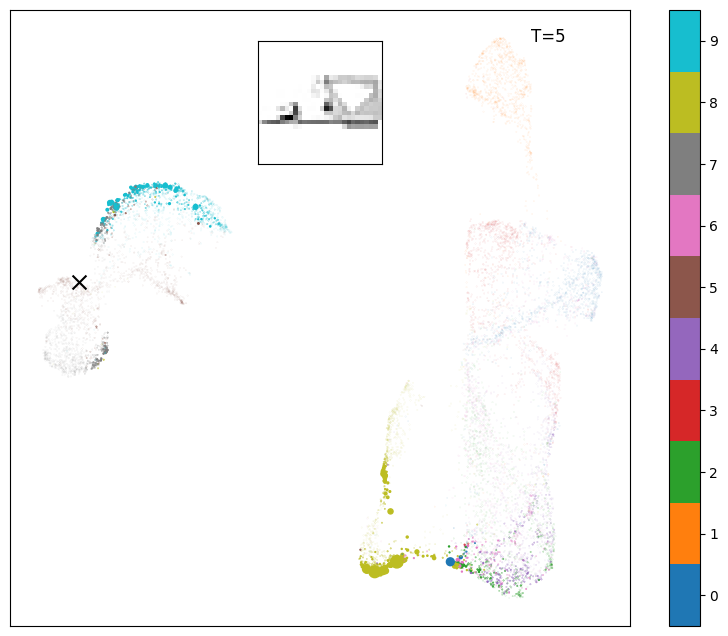

In [123]:
activ = topk_dists.data.cpu().numpy()[0]

print(f"index:{i}/{len(dists)}")
fig = plt.figure(figsize=(10,8))

plt.scatter(embedding[:,0], embedding[:, 1], c=test_dataset.targets, s=np.maximum(activ*80, 0.001), cmap="tab10")
#     plt.scatter(embedding[:,0], embedding[:, 1], c=output_cent, s=np.maximum(activ*80, 0.0), cmap="tab10")

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

ins = plt.gca().inset_axes([0.4,0.75,0.2,0.2])
ins.imshow(xx[i].numpy().reshape(28, 28), cmap='gray_r')
ins.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

plt.scatter(xtransf[i,0], xtransf[i,1], marker='x', color='k', s=100)

plt.text(.84, .97, f'T={int(yy[i])}', ha='left', va='top', transform=fig.axes[0].transAxes, fontsize="large")
# plt.savefig(f"./outputs/03.4_visualize/umap_scaled_actf_linear_i{i}.pdf", bbox_inches='tight')
plt.show()


In [113]:
torch.topk(dists, k=50,dim=1)[0]

tensor([[363.8758, 361.2250, 358.1342, 355.0505, 354.5446, 354.0827, 353.9117,
         353.6676, 353.4123, 353.0099, 352.3110, 351.7428, 351.5322, 351.2151,
         350.9629, 350.7858, 350.7780, 350.4987, 350.4045, 350.2435, 350.1528,
         350.1375, 350.1173, 349.8081, 349.7466, 349.2322, 349.1768, 349.0590,
         349.0090, 348.9314, 348.9042, 348.8812, 348.5566, 348.5035, 348.4045,
         348.3958, 348.2075, 348.0255, 347.8695, 347.7352, 347.6697, 347.6149,
         347.6057, 347.5409, 347.4572, 347.2210, 346.9985, 346.9753, 346.8378,
         346.6897]])

# Other Vizz Try !!

### Visualize for Cosine based Umap - and Cosine angle activation

In [40]:
embed2 = umap.UMAP(n_neighbors=50, n_components=2, min_dist=0.1, spread=1, metric='cosine')
# embed = umap.UMAP(n_neighbors=784, n_components=2, min_dist=0.1, spread=1,
# #                   target_metric='euclidean',
#                   target_metric='categorical',
#                   target_weight=0.1
#                  )

In [41]:
embedding2 = embed2.fit_transform(selected_points)
# embedding = embed.fit_transform(centers, output_cent)

In [42]:
xtransf2 = embed2.transform(xx.numpy().reshape(-1, 28*28))

In [43]:
transform3 = nn.Linear(28*28, len(test_dataset))
transform3.weight.data = selected_points/torch.norm(selected_points, dim=1, keepdim=True)

In [44]:
selected_points.shape

torch.Size([10000, 784])

In [45]:
i = -1

In [89]:
i += 1
with torch.no_grad():
    xx_ = xx[i:i+1]
    xx_ /= torch.norm(xx_, dim=1, keepdim=True)
    dists = -transform3(xx_)
dists.shape
print(yy[i])

tensor(7)


In [90]:
dists = dists-dists.min(dim=1, keepdim=True)[0]
sigma = get_sigma(dists, k=10000, lr=0.002)
topk_dists = torch.exp(-dists/sigma)

Parameter containing:
tensor([[0.0295]], requires_grad=True) tensor([[13.2877]])
tensor([[21.6641]]) tensor([[0.0295]])
tensor([[18.2010]]) tensor([[0.0275]])
tensor([[15.2901]]) tensor([[0.0257]])
tensor([[13.0040]]) tensor([[0.0240]])
tensor([[11.3382]]) tensor([[0.0227]])
tensor([[10.2183]]) tensor([[0.0217]])
tensor([[9.5434]]) tensor([[0.0211]])
tensor([[9.2219]]) tensor([[0.0208]])
tensor([[9.1834]]) tensor([[0.0208]])
tensor([[9.3778]]) tensor([[0.0210]])
tensor([[9.7691]]) tensor([[0.0213]])
tensor([[10.3282]]) tensor([[0.0218]])
tensor([[11.0268]]) tensor([[0.0224]])
tensor([[11.8311]]) tensor([[0.0231]])
tensor([[12.6964]]) tensor([[0.0238]])
tensor([[13.5625]]) tensor([[0.0244]])
tensor([[14.3551]]) tensor([[0.0250]])
tensor([[14.9944]]) tensor([[0.0255]])
tensor([[15.4129]]) tensor([[0.0258]])
tensor([[15.5739]]) tensor([[0.0259]])
tensor([[15.4808]]) tensor([[0.0258]])
tensor([[15.1725]]) tensor([[0.0256]])
tensor([[14.7102]]) tensor([[0.0253]])
tensor([[14.1630]]) tensor(

tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tenso

tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tensor([[0.0242]])
tensor([[13.2877]]) tenso

In [91]:
topk_dists.max(), topk_dists.min()

(tensor(1.), tensor(7.5330e-18))

index:9/1


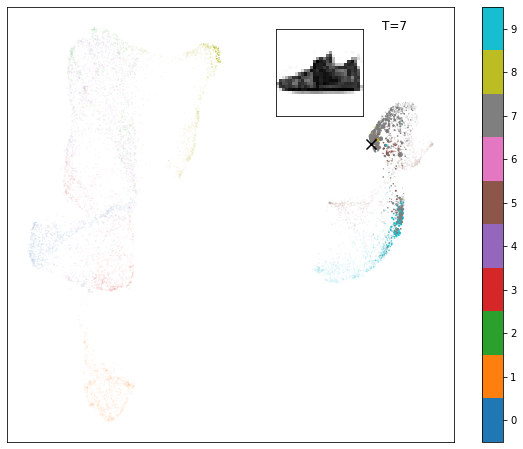

In [92]:
activ = topk_dists.data.cpu().numpy()[0]

print(f"index:{i}/{len(dists)}")
fig = plt.figure(figsize=(10,8))

plt.scatter(embedding[:,0], embedding[:, 1], c=test_dataset.targets, s=np.maximum(activ*80, 0.001), cmap="tab10")
#     plt.scatter(embedding[:,0], embedding[:, 1], c=output_cent, s=np.maximum(activ*80, 0.0), cmap="tab10")

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

ins = plt.gca().inset_axes([0.6,0.75,0.2,0.2])
ins.imshow(xx[i].numpy().reshape(28, 28), cmap='gray_r')
ins.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

plt.scatter(xtransf[i,0], xtransf[i,1], marker='x', color='k', s=100)

plt.text(.84, .97, f'T={int(yy[i])}', ha='left', va='top', transform=fig.axes[0].transAxes, fontsize="large")

plt.show()


index:8/1


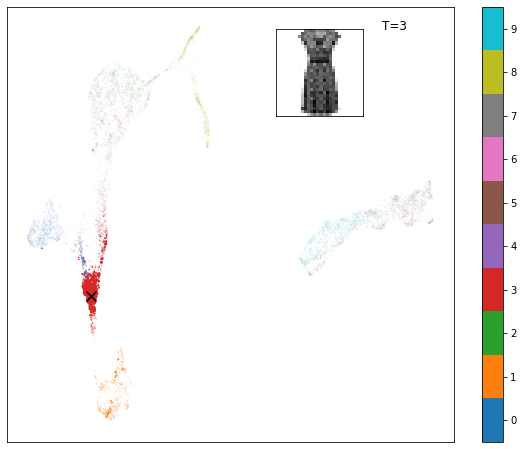

In [88]:
activ = topk_dists.data.cpu().numpy()[0]

print(f"index:{i}/{len(dists)}")
fig = plt.figure(figsize=(10,8))

plt.scatter(embedding2[:,0], embedding2[:, 1], c=test_dataset.targets, s=np.maximum(activ*80, 0.001), cmap="tab10")
#     plt.scatter(embedding[:,0], embedding[:, 1], c=output_cent, s=np.maximum(activ*80, 0.0), cmap="tab10")

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

ins = plt.gca().inset_axes([0.6,0.75,0.2,0.2])
ins.imshow(xx[i].numpy().reshape(28, 28), cmap='gray_r')
ins.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

plt.scatter(xtransf2[i,0], xtransf2[i,1], marker='x', color='k', s=100)

plt.text(.84, .97, f'T={int(yy[i])}', ha='left', va='top', transform=fig.axes[0].transAxes, fontsize="large")

plt.show()


### Visualize for Dot-product based Umap - and Dot-product activation

In [184]:
import numba

In [199]:
@numba.njit(fastmath=True)
def dot_product_grad(x, y):
    dot = 0.0
    for i in range(x.shape[0]):
        dot += x[i] * y[i]
    grad = y
    return -dot, -grad

In [200]:
embed = umap.UMAP(n_neighbors=50, n_components=2, min_dist=0.1, spread=1, metric=dot_product_grad)
# embed = umap.UMAP(n_neighbors=784, n_components=2, min_dist=0.1, spread=1,
# #                   target_metric='euclidean',
#                   target_metric='categorical',
#                   target_weight=0.1
#                  )

In [201]:
# selected_points.max()

In [202]:
embedding = embed.fit_transform(selected_points)
# embedding = embed.fit_transform(centers, output_cent)

In [203]:
xtransf = embed.transform(xx.numpy().reshape(-1, 28*28))

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [204]:
transform2 = nn.Linear(28*28, len(test_dataset))
transform2.weight.data = selected_points

In [205]:
i = -1

In [206]:
i += 1
with torch.no_grad():
    dists = -transform2(xx[i:i+1])
dists.shape
print(yy[i])

tensor(2)


In [207]:
dists = dists-dists.min(dim=1, keepdim=True)[0]
sigma = get_sigma(dists, k=10000, lr=0.002)
topk_dists = torch.exp(-dists/sigma)

Parameter containing:
tensor([[0.6660]], requires_grad=True) tensor([[13.2877]])
tensor([[70.1329]]) tensor([[0.6660]])
tensor([[69.7164]]) tensor([[0.6640]])
tensor([[69.3013]]) tensor([[0.6620]])
tensor([[68.8875]]) tensor([[0.6600]])
tensor([[68.4752]]) tensor([[0.6580]])
tensor([[68.0644]]) tensor([[0.6560]])
tensor([[67.6553]]) tensor([[0.6540]])
tensor([[67.2478]]) tensor([[0.6520]])
tensor([[66.8421]]) tensor([[0.6500]])
tensor([[66.4382]]) tensor([[0.6481]])
tensor([[66.0362]]) tensor([[0.6461]])
tensor([[65.6362]]) tensor([[0.6441]])
tensor([[65.2382]]) tensor([[0.6421]])
tensor([[64.8423]]) tensor([[0.6402]])
tensor([[64.4485]]) tensor([[0.6382]])
tensor([[64.0569]]) tensor([[0.6362]])
tensor([[63.6675]]) tensor([[0.6343]])
tensor([[63.2805]]) tensor([[0.6323]])
tensor([[62.8958]]) tensor([[0.6304]])
tensor([[62.5135]]) tensor([[0.6284]])
tensor([[62.1336]]) tensor([[0.6265]])
tensor([[61.7562]]) tensor([[0.6246]])
tensor([[61.3813]]) tensor([[0.6227]])
tensor([[61.0089]]) te

tensor([[21.5311]]) tensor([[0.3651]])
tensor([[21.4835]]) tensor([[0.3647]])
tensor([[21.4362]]) tensor([[0.3642]])
tensor([[21.3893]]) tensor([[0.3638]])
tensor([[21.3426]]) tensor([[0.3634]])
tensor([[21.2963]]) tensor([[0.3630]])
tensor([[21.2502]]) tensor([[0.3626]])
tensor([[21.2044]]) tensor([[0.3622]])
tensor([[21.1589]]) tensor([[0.3618]])
tensor([[21.1138]]) tensor([[0.3613]])
tensor([[21.0689]]) tensor([[0.3609]])
tensor([[21.0243]]) tensor([[0.3605]])
tensor([[20.9799]]) tensor([[0.3601]])
tensor([[20.9359]]) tensor([[0.3597]])
tensor([[20.8921]]) tensor([[0.3593]])
tensor([[20.8486]]) tensor([[0.3590]])
tensor([[20.8054]]) tensor([[0.3586]])
tensor([[20.7625]]) tensor([[0.3582]])
tensor([[20.7198]]) tensor([[0.3578]])
tensor([[20.6774]]) tensor([[0.3574]])
tensor([[20.6353]]) tensor([[0.3570]])
tensor([[20.5934]]) tensor([[0.3566]])
tensor([[20.5518]]) tensor([[0.3563]])
tensor([[20.5104]]) tensor([[0.3559]])
tensor([[20.4694]]) tensor([[0.3555]])
tensor([[20.4285]]) tenso

tensor([[14.9019]]) tensor([[0.2998]])
tensor([[14.8928]]) tensor([[0.2997]])
tensor([[14.8837]]) tensor([[0.2996]])
tensor([[14.8747]]) tensor([[0.2995]])
tensor([[14.8657]]) tensor([[0.2994]])
tensor([[14.8567]]) tensor([[0.2993]])
tensor([[14.8478]]) tensor([[0.2992]])
tensor([[14.8390]]) tensor([[0.2991]])
tensor([[14.8302]]) tensor([[0.2990]])
tensor([[14.8214]]) tensor([[0.2989]])
tensor([[14.8127]]) tensor([[0.2988]])
tensor([[14.8040]]) tensor([[0.2987]])
tensor([[14.7954]]) tensor([[0.2986]])
tensor([[14.7868]]) tensor([[0.2985]])
tensor([[14.7783]]) tensor([[0.2984]])
tensor([[14.7698]]) tensor([[0.2983]])
tensor([[14.7613]]) tensor([[0.2982]])
tensor([[14.7529]]) tensor([[0.2981]])
tensor([[14.7446]]) tensor([[0.2980]])
tensor([[14.7363]]) tensor([[0.2979]])
tensor([[14.7280]]) tensor([[0.2978]])
tensor([[14.7198]]) tensor([[0.2977]])
tensor([[14.7116]]) tensor([[0.2977]])
tensor([[14.7035]]) tensor([[0.2976]])
tensor([[14.6954]]) tensor([[0.2975]])
tensor([[14.6873]]) tenso

In [208]:
topk_dists.max(), topk_dists.min()

(tensor(1.), tensor(1.5284e-23))

index:0/1


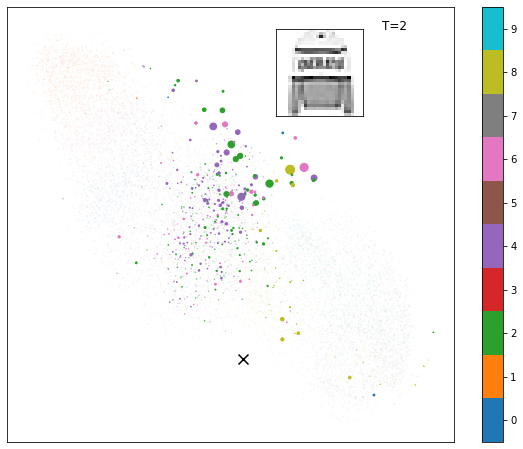

In [209]:
activ = topk_dists.data.cpu().numpy()[0]

print(f"index:{i}/{len(dists)}")
fig = plt.figure(figsize=(10,8))

plt.scatter(embedding[:,0], embedding[:, 1], c=test_dataset.targets, s=np.maximum(activ*80, 0.001), cmap="tab10")
#     plt.scatter(embedding[:,0], embedding[:, 1], c=output_cent, s=np.maximum(activ*80, 0.0), cmap="tab10")

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

ins = plt.gca().inset_axes([0.6,0.75,0.2,0.2])
ins.imshow(xx[i].numpy().reshape(28, 28), cmap='gray_r')
ins.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

plt.scatter(xtransf[i,0], xtransf[i,1], marker='x', color='k', s=100)

plt.text(.84, .97, f'T={int(yy[i])}', ha='left', va='top', transform=fig.axes[0].transAxes, fontsize="large")

plt.show()
